In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import geohash as gh
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

%matplotlib inline

Read file to dataframe:

In [2]:
df = pd.read_csv('/Users/User/Downloads/traffic-management/Traffic Management/training.csv')

Extract features from dataframe:

In [3]:
# create list of latitude and longitude for the unique set of geohashes
lat = {x: float(gh.decode_exactly(x)[0]) for x in list(set(df.geohash6))}
lon = {x: float(gh.decode_exactly(x)[1]) for x in list(set(df.geohash6))}
# create new columns of latitude and longitude based on geohashes
df['lat'] = df['geohash6'].apply(lambda x: lat.get(x))
df['lon'] = df['geohash6'].apply(lambda x: lon.get(x))
# replace geohashes with numerical codes for ease of analysis
y = pd.Series(df['geohash6']).astype('category')
df.geohash6 = y.cat.codes
# create new columns of hour and minute
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M')
df[['hour','minute']] = pd.DataFrame([(d.hour, d.minute) for d in df['timestamp']])
df = df.drop('timestamp',axis=1)
# re-order columns 
df = df[['geohash6','lat','lon','day','hour','minute','demand']]

In [4]:
df.head(1)

,geohash6,lat,lon,day,hour,minute,demand
0,212,-5.353088,90.653687,18,20,0,0.020072


# Data Visualisation

## Demand Heatmap by Hour and Minute

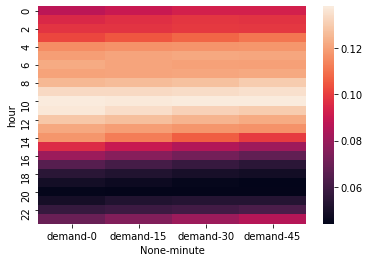

In [5]:
df_by_HM = df.groupby(['hour','minute']).mean()
df_by_HM = df_by_HM.drop(['geohash6','day','lat','lon'],axis=1)
df_by_HM = df_by_HM.unstack()
sns.heatmap(df_by_HM)

plt.show()

# Demand Heatmap by Hour and Day

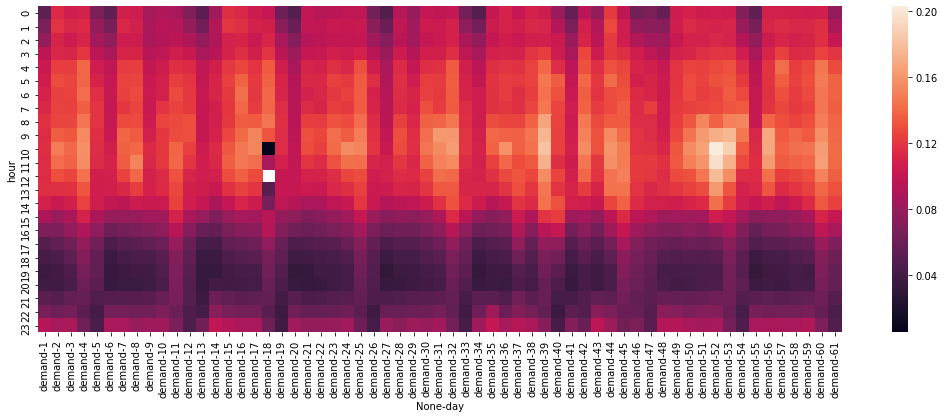

In [6]:
plt.figure(figsize=(18,6))

df_by_HD = df.groupby(['hour','day']).mean()
df_by_HD = df_by_HD.drop(['geohash6','minute','lat','lon'],axis=1)
df_by_HD = df_by_HD.unstack()
sns.heatmap(df_by_HD)

plt.show()

## Demand Bar Plot by Day

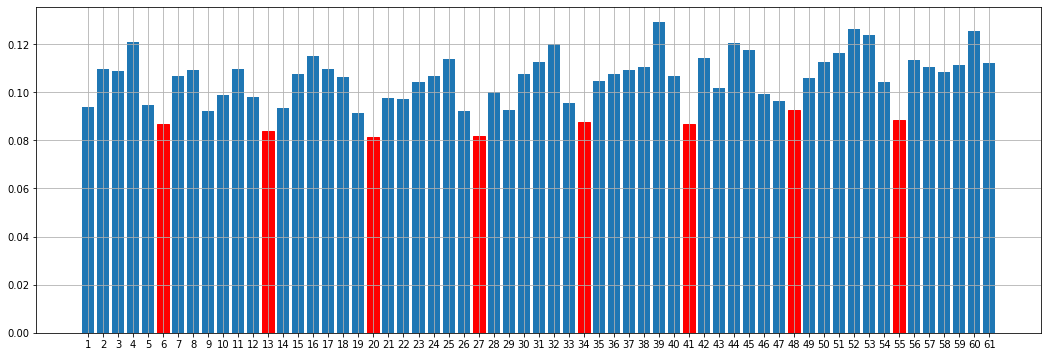

In [7]:
df_by_day = df.groupby(['day'],as_index=False).mean()
plt.figure(figsize=(18,6))
barlist = plt.bar(df_by_day.day,df_by_day.demand)
for item in barlist[5::7]:
    item.set_color('r')
plt.xticks(np.arange(min(df_by_day.day), max(df_by_day.day)+1, 1.0))
plt.grid()
plt.show()

## Demand Heatmap by Location at 6-Hour Interval

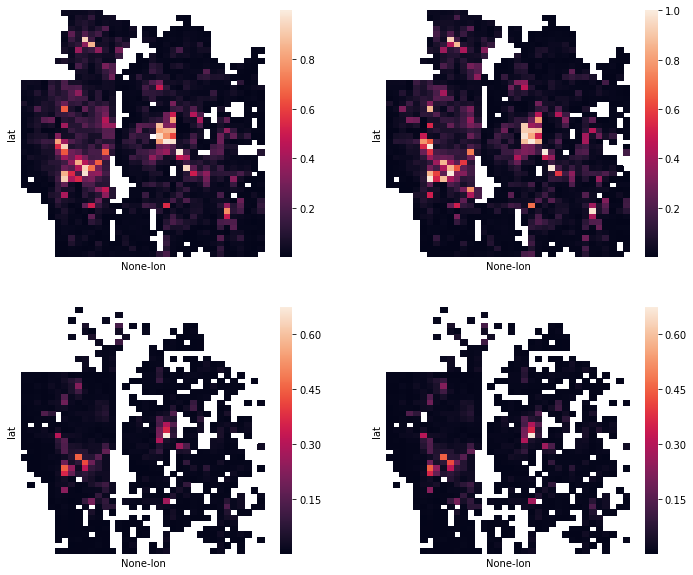

In [8]:
fig, axn = plt.subplots(2,2, sharey=True, figsize = (12,10))

# Heatmap at 6th Hour
plt.subplot(2,2,1)
df_by_loc_6 = df[df.hour==6]
df_by_loc_6 = df_by_loc_6.groupby(['lat','lon']).mean()
df_by_loc_6 = df_by_loc_6.drop(['geohash6','day','hour','minute'],axis=1)
df_by_loc_6 = df_by_loc_6.unstack()
sns.heatmap(df_by_loc_6,xticklabels=False, yticklabels=False)
# Heatmap at 12th Hour
plt.subplot(2,2,2)
df_by_loc_12 = df[df.hour==12]
df_by_loc_12 = df_by_loc_12.groupby(['lat','lon']).mean()
df_by_loc_12 = df_by_loc_12.drop(['geohash6','day','hour','minute'],axis=1)
df_by_loc_12 = df_by_loc_12.unstack()
sns.heatmap(df_by_loc_12,xticklabels=False, yticklabels=False)
# Heatmap at 18th Hour
plt.subplot(2,2,3)
df_by_loc_18 = df[df.hour==18]
df_by_loc_18 = df_by_loc_18.groupby(['lat','lon']).mean()
df_by_loc_18 = df_by_loc_18.drop(['geohash6','day','hour','minute'],axis=1)
df_by_loc_18 = df_by_loc_18.unstack()
sns.heatmap(df_by_loc_18,xticklabels=False, yticklabels=False)
# Heatmap at 0th Hour
plt.subplot(2,2,4)
df_by_loc_0 = df[df.hour==18]
df_by_loc_0 = df_by_loc_0.groupby(['lat','lon']).mean()
df_by_loc_0 = df_by_loc_0.drop(['geohash6','day','hour','minute'],axis=1)
df_by_loc_0 = df_by_loc_0.unstack()
sns.heatmap(df_by_loc_0,xticklabels=False, yticklabels=False)

plt.show()

Based on the visualisation above, we can add features to the dataset to improve the prediction.
- Assigning Mondays to Sundays to the days; We will assign 1 to the day with the lowest demand which occurs every 7 days (possibly Mondays)
- Tag day 6 and 7 as weekends

# Feature Creation

In [9]:
# assign day 
day2 = list(np.tile(list(range(1,8)),9))
day2 = day2[2:]
day = list(range(1,62))
dict_day = dict(zip(day,day2))
df['day_number'] = df['day'].map(dict_day)
# assign week number
week_number_dict = dict(zip(day,np.repeat(list(range(1,10)),7)[2:]))
df['week_number'] = df['day'].map(week_number_dict)
# assign weekends
weekend_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:1}
df['is_weekend'] = df['day_number'].map(weekend_dict)
# re-order columns 
df = df[['geohash6','lat','lon','day','week_number','day_number','is_weekend','hour','minute','demand']]

In [10]:
df = df.drop(['lat','lon','day'], axis=1)
df.head(5)

,geohash6,week_number,day_number,is_weekend,hour,minute,demand
0,212,3,6,1,20,0,0.020072
1,94,2,5,0,14,30,0.024721
2,1056,2,4,0,6,15,0.102821
3,703,5,6,1,5,0,0.088755
4,460,3,3,0,4,0,0.074468


# XGBoost

In [11]:
# create hold-out dataset
X, y = df.iloc[:,:-1],df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')

params_list = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 11)],
              'learning_rate': [round(x,2) for x in np.linspace(start = 0.05, stop = 1, num = 20)],
              'subsample': [round(x,2) for x in np.linspace(start = 0.3, stop = 0.7, num = 9)],
              'max_depth': [int(x) for x in np.linspace(start = 3, stop = 30, num = 8)],
              'colsample_bytree': [0.5, 0.45],
              'min_child_weight': [1, 2, 3]}

reg = RandomizedSearchCV(xgb_model, param_distributions = params_list, cv=3, n_iter = 3, scoring = 'neg_mean_squared_error', verbose = 3, n_jobs = -1)

# predict
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
print(reg.best_params_)

# RMSE
print("RMSE: %f" % (np.sqrt(mean_squared_error(y_test, preds))))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  1.2min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.6min remaining:   47.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.8min finished
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'subsample': 0.4, 'n_estimators': 40, 'min_child_weight': 2, 'max_depth': 18, 'learning_rate': 0.4, 'colsample_bytree': 0.5}
RMSE: 0.041938


# Random Forest

In [12]:
rf = RandomForestRegressor()

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 40, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 50, num = 9)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
predictions = rf_random.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
print('RMSE:',round(rmse,5)) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   48.6s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.9min finished


RMSE: 0.03322
